In [ ]:
# Kiểm tra GPU
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")

if tf.config.list_physical_devices('GPU'):
    print("✅ GPU được kích hoạt - Training sẽ nhanh!")
else:
    print("⚠️  Chỉ có CPU - Hãy bật GPU: Runtime > Change runtime type > GPU")


TensorFlow version: 2.19.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
✅ GPU được kích hoạt - Training sẽ nhanh!


In [ ]:
# Import các thư viện cần thiết
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

print("✅ Import thành công!")


✅ Import thành công!


📥 Đang tải MNIST dataset...
11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Train shape: (60000, 28, 28)
Test shape: (10000, 28, 28)


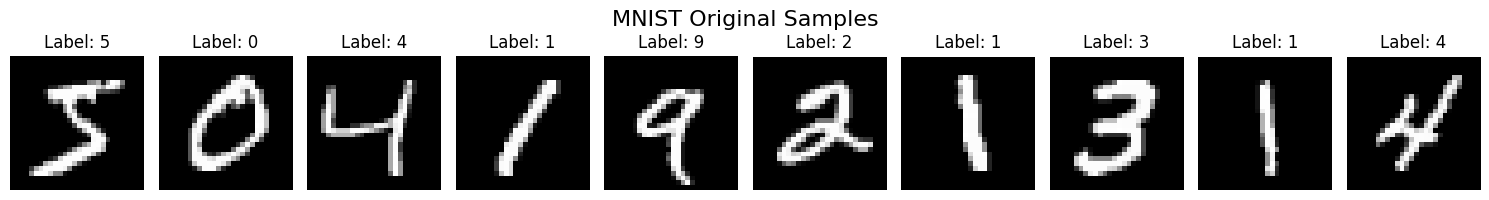

In [ ]:
# Load MNIST dataset
print("📥 Đang tải MNIST dataset...")
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

print(f"Train shape: {x_train.shape}")
print(f"Test shape: {x_test.shape}")

# Hiển thị một vài mẫu
fig, axes = plt.subplots(1, 10, figsize=(15, 2))
for i, ax in enumerate(axes):
    ax.imshow(x_train[i], cmap='gray')
    ax.set_title(f"Label: {y_train[i]}")
    ax.axis('off')
plt.suptitle('MNIST Original Samples', fontsize=16)
plt.tight_layout()
plt.show()


In [ ]:
# Preprocess data
print("🔄 Preprocessing data...")

# Reshape và normalize về [0, 1]
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0

# Convert labels to categorical (one-hot encoding)
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

print(f"✅ X_train: {x_train.shape}, Y_train: {y_train.shape}")
print(f"✅ X_test: {x_test.shape}, Y_test: {y_test.shape}")


🔄 Preprocessing data...
✅ X_train: (60000, 28, 28, 1), Y_train: (60000, 10)
✅ X_test: (10000, 28, 28, 1), Y_test: (10000, 10)


In [ ]:
# Tạo Data Augmentation Generator
print("🎨 Tạo Data Augmentation Generator...")

datagen = ImageDataGenerator(
    rotation_range=15,       # Ngẫu nhiên xoay +/- 15 độ
    width_shift_range=0.15,  # Ngẫu nhiên dịch ngang 15%
    height_shift_range=0.15, # Ngẫu nhiên dịch dọc 15%
    zoom_range=0.15,         # Ngẫu nhiên phóng to/thu nhỏ 15%
    shear_range=0.1,         # Ngẫu nhiên làm méo ảnh (nghiêng)
    fill_mode='constant',    # Fill phần trống bằng màu đen (0)
    cval=0
)

# Fit datagen vào training data
datagen.fit(x_train)

print("✅ Data Augmentation Generator ready!")
print("   → Model sẽ học từ ảnh đã được 'làm bẩn' (augmented)")
print("   → Model sẽ khoan dung hơn với ảnh thực tế!")


🎨 Tạo Data Augmentation Generator...
✅ Data Augmentation Generator ready!
   → Model sẽ học từ ảnh đã được 'làm bẩn' (augmented)
   → Model sẽ khoan dung hơn với ảnh thực tế!


📊 Demo: So sánh ảnh gốc vs ảnh augmented


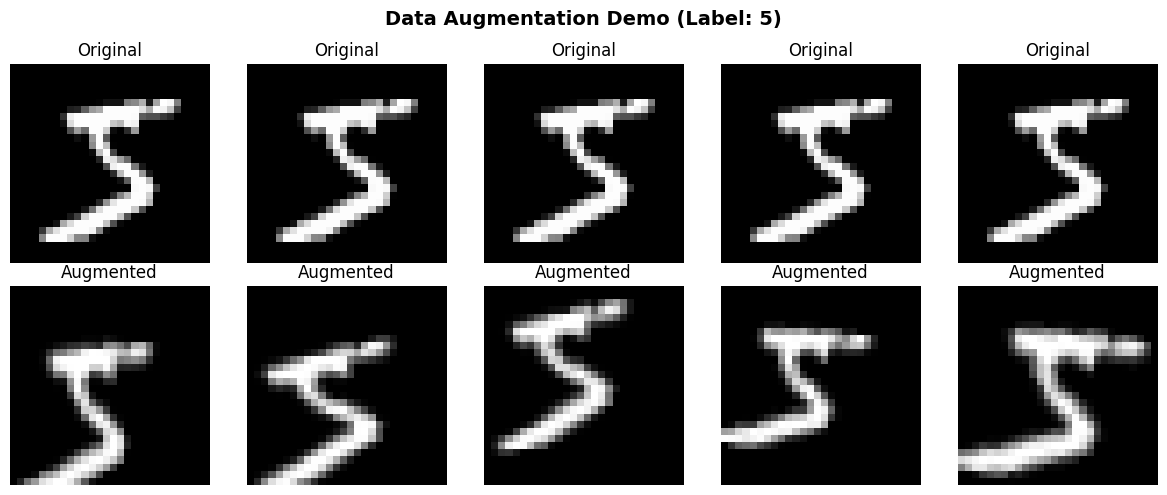

👀 Quan sát: Ảnh augmented bị xoay, dịch, zoom, méo → Giống ảnh thực tế hơn!


In [ ]:
# Demo: Hiển thị ảnh gốc vs ảnh đã augmented
print("📊 Demo: So sánh ảnh gốc vs ảnh augmented")

# Lấy 1 ảnh mẫu
sample_img = x_train[0:1]  # Shape (1, 28, 28, 1)
sample_label = np.argmax(y_train[0])

# Tạo augmented images
fig, axes = plt.subplots(2, 5, figsize=(12, 5))

# Hàng 1: Ảnh gốc
for i in range(5):
    axes[0, i].imshow(sample_img[0].reshape(28, 28), cmap='gray')
    axes[0, i].set_title('Original')
    axes[0, i].axis('off')

# Hàng 2: Ảnh augmented
aug_iter = datagen.flow(sample_img, batch_size=1)
for i in range(5):
    aug_img = next(aug_iter)[0]
    axes[1, i].imshow(aug_img.reshape(28, 28), cmap='gray')
    axes[1, i].set_title('Augmented')
    axes[1, i].axis('off')

plt.suptitle(f'Data Augmentation Demo (Label: {sample_label})', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("👀 Quan sát: Ảnh augmented bị xoay, dịch, zoom, méo → Giống ảnh thực tế hơn!")


In [ ]:
# Tạo CNN Model
print("🏗️  Building CNN Model...")

model = keras.Sequential([
    # Input layer
    layers.Input(shape=(28, 28, 1)),

    # Convolutional Block 1
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),

    # Convolutional Block 2
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),

    # Convolutional Block 3
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.Dropout(0.25),

    # Fully Connected Layers
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

# Compile model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Hiển thị summary
model.summary()

print("\n✅ Model đã sẵn sàng!")


🏗️  Building CNN Model...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 458,570 (1.75 MB)

 Trainable params: 458,570 (1.75 MB)

 Non-trainable params: 0 (0.00 B)


✅ Model đã sẵn sàng!


In [ ]:
# Thiết lập callbacks
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        verbose=1
    )
]

print("✅ Callbacks configured!")


✅ Callbacks configured!


In [ ]:
# 🚀 TRAINING với Data Augmentation!
print("="*70)
print("🎯 BẮT ĐẦU TRAINING VỚI DATA AUGMENTATION")
print("="*70)
print("⏰ Ước tính: 15-20 phút trên GPU Colab")
print("")

EPOCHS = 30
BATCH_SIZE = 128

history = model.fit(
    # ⚠️ QUAN TRỌNG: Sử dụng datagen.flow() thay vì x_train trực tiếp
    datagen.flow(x_train, y_train, batch_size=BATCH_SIZE),

    epochs=EPOCHS,

    # Validation data KHÔNG augment (giữ nguyên)
    validation_data=(x_test, y_test),

    # Số steps mỗi epoch
    steps_per_epoch=len(x_train) // BATCH_SIZE,

    callbacks=callbacks,
    verbose=1
)

print("\n" + "="*70)
print("✅ TRAINING HOÀN THÀNH!")
print("="*70)


🎯 BẮT ĐẦU TRAINING VỚI DATA AUGMENTATION
⏰ Ước tính: 15-20 phút trên GPU Colab

Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


468/468 ━━━━━━━━━━━━━━━━━━━━ 32s 53ms/step - accuracy: 0.5918 - loss: 1.1760 - val_accuracy: 0.9779 - val_loss: 0.0691 - learning_rate: 0.0010
Epoch 2/30
  1/468 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9453 - loss: 0.2531

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


468/468 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9453 - loss: 0.2531 - val_accuracy: 0.9780 - val_loss: 0.0691 - learning_rate: 0.0010
Epoch 3/30
468/468 ━━━━━━━━━━━━━━━━━━━━ 30s 42ms/step - accuracy: 0.9191 - loss: 0.2695 - val_accuracy: 0.9840 - val_loss: 0.0471 - learning_rate: 0.0010
Epoch 4/30
468/468 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8984 - loss: 0.2988 - val_accuracy: 0.9846 - val_loss: 0.0457 - learning_rate: 0.0010
Epoch 5/30
468/468 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - accuracy: 0.9438 - loss: 0.1935 - val_accuracy: 0.9871 - val_loss: 0.0398 - learning_rate: 0.0010
Epoch 6/30
468/468 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9766 - loss: 0.1155 - val_accuracy: 0.9880 - val_loss: 0.0368 - learning_rate: 0.0010
Epoch 7/30
468/468 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - accuracy: 0.9524 - loss: 0.1616 - val_accuracy: 0.9912 - val_loss: 0.0271 - learning_rate: 0.0010
Epoch 8/30
468/468 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9453 - loss: 0.2351 - val_a

In [ ]:
# Evaluate trên test set
print("📊 Đánh giá model trên test set...")
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)

print("\n" + "="*70)
print("📈 KẾT QUẢ CUỐI CÙNG")
print("="*70)
print(f"✅ Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"✅ Test Loss: {test_loss:.4f}")
print("="*70)


📊 Đánh giá model trên test set...

📈 KẾT QUẢ CUỐI CÙNG
✅ Test Accuracy: 0.9948 (99.48%)
✅ Test Loss: 0.0138


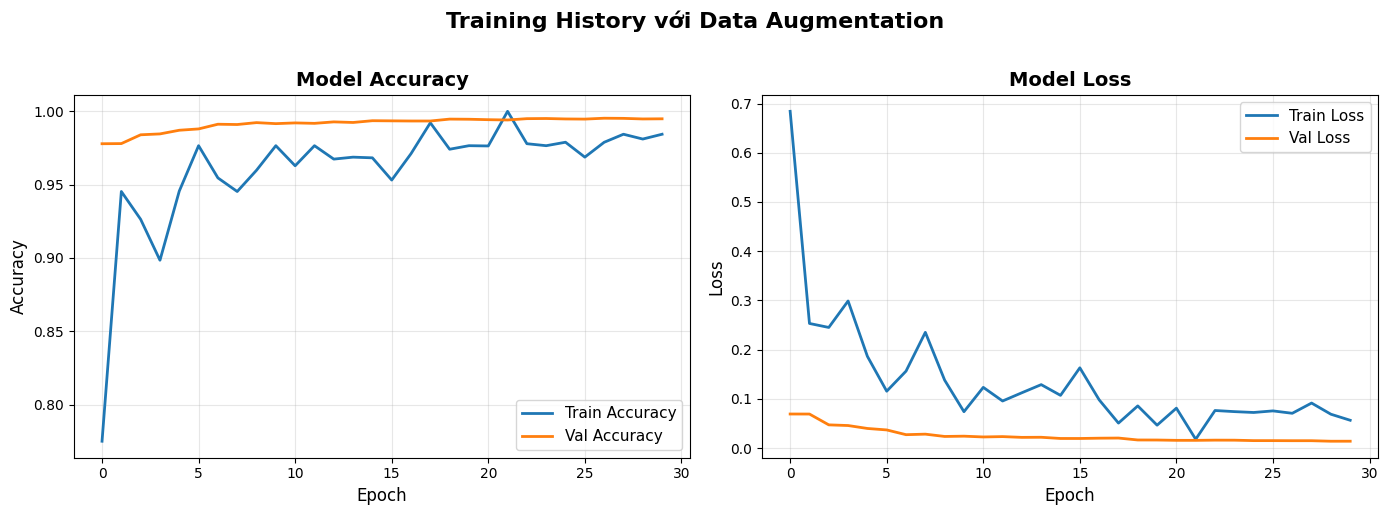

✅ Training history plotted!


In [ ]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy plot
ax1.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
ax1.plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
ax1.set_title('Model Accuracy', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Loss plot
ax2.plot(history.history['loss'], label='Train Loss', linewidth=2)
ax2.plot(history.history['val_loss'], label='Val Loss', linewidth=2)
ax2.set_title('Model Loss', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.suptitle('Training History với Data Augmentation', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("✅ Training history plotted!")


🧪 Testing predictions trên một vài mẫu ngẫu nhiên...



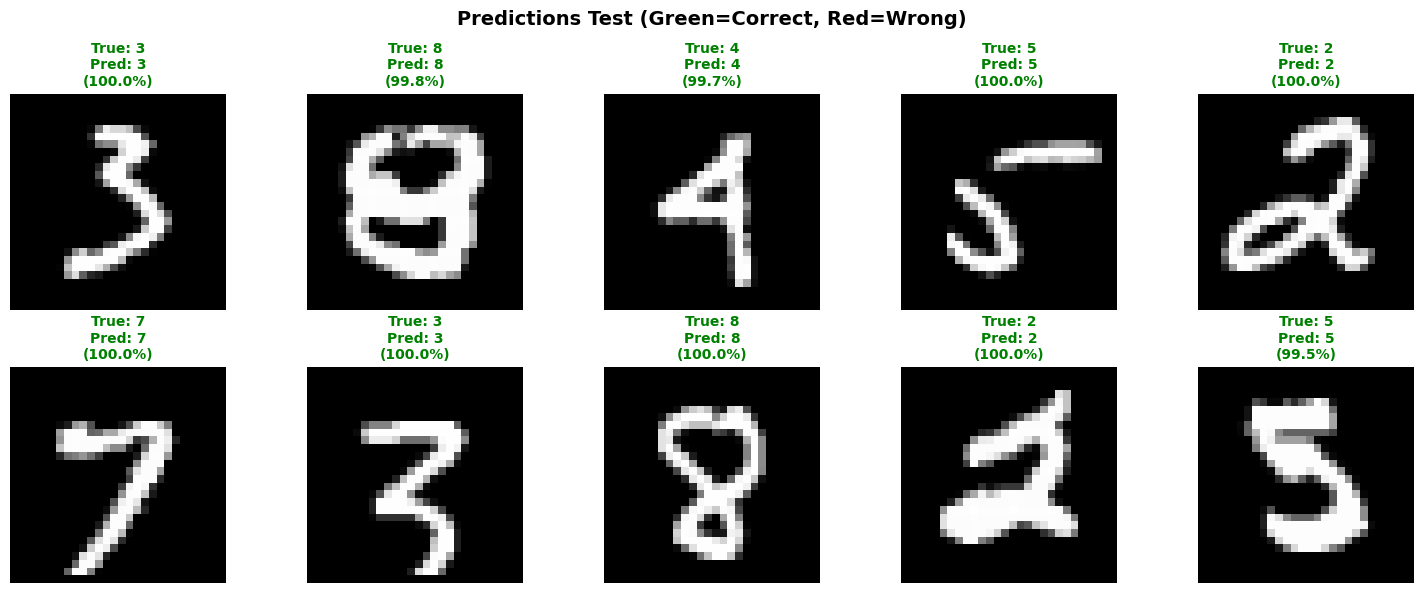


✅ Accuracy trên 10 mẫu: 10/10 (100%)


In [ ]:
# Test predictions với một vài mẫu ngẫu nhiên
print("🧪 Testing predictions trên một vài mẫu ngẫu nhiên...\n")

# Chọn 10 ảnh ngẫu nhiên
indices = np.random.choice(len(x_test), 10, replace=False)
sample_images = x_test[indices]
sample_labels = y_test[indices]

# Predict
predictions = model.predict(sample_images, verbose=0)

# Visualize
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

for i in range(10):
    true_label = np.argmax(sample_labels[i])
    pred_label = np.argmax(predictions[i])
    confidence = predictions[i][pred_label] * 100

    # Hiển thị ảnh
    axes[i].imshow(sample_images[i].reshape(28, 28), cmap='gray')

    # Màu xanh nếu đúng, đỏ nếu sai
    color = 'green' if true_label == pred_label else 'red'
    axes[i].set_title(f"True: {true_label}\nPred: {pred_label}\n({confidence:.1f}%)",
                      color=color, fontsize=10, fontweight='bold')
    axes[i].axis('off')

plt.suptitle('Predictions Test (Green=Correct, Red=Wrong)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# In ra accuracy
correct = sum([np.argmax(sample_labels[i]) == np.argmax(predictions[i]) for i in range(10)])
print(f"\n✅ Accuracy trên 10 mẫu: {correct}/10 ({correct*10}%)")


In [ ]:
# Lưu model
model_path = 'mnist_model_augmented.h5'
model.save(model_path)

print(f"✅ Model đã được lưu tại: {model_path}")
print(f"📦 Kích thước file: {os.path.getsize(model_path) / (1024*1024):.2f} MB")


✅ Model đã được lưu tại: mnist_model_augmented.h5
📦 Kích thước file: 5.30 MB


In [ ]:
# Download model về máy local
from google.colab import files

print("📥 Đang chuẩn bị download model...")
files.download(model_path)
print("✅ Download hoàn tất!")
print("\n💡 Hướng dẫn:")
print("   1. File sẽ được tải về thư mục Downloads")
print("   2. Di chuyển file 'mnist_model_augmented.h5' vào thư mục 'models/' của project")
print("   3. Đổi tên thành 'mnist_model.h5' (hoặc update code app.py)")
print("   4. Chạy lại Streamlit app: streamlit run app.py")
print("   5. Enjoy! 🎉")


📥 Đang chuẩn bị download model...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Download hoàn tất!

💡 Hướng dẫn:
   1. File sẽ được tải về thư mục Downloads
   2. Di chuyển file 'mnist_model_augmented.h5' vào thư mục 'models/' của project
   3. Đổi tên thành 'mnist_model.h5' (hoặc update code app.py)
   4. Chạy lại Streamlit app: streamlit run app.py
   5. Enjoy! 🎉
